# SANS simulations

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
np.random.seed(1)

In [2]:
np.random.seed(1)

region = df.Region(p1=(-40e-9, -40e-9, -40e-9), p2=(40e-9, 40e-9, 40e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))

system = mm.System(name='Box2')

#system.energy = (mm.Exchange(A=10e-12)
#                 + mm.DMI(D=2e-3, crystalclass='T')
#                 + mm.Demag()
#                 + mm.Zeeman(H=(0,0,0.8/(4*np.pi*1e-7))))

system.energy = mm.Exchange(A=1.2e-11) + mm.Demag()

#Ms = 4.2/(4*np.pi*1e-7)
Ms = 1.4e6
def norm_fun(pos):
    x, y, z = pos
    
    if x**2 + y**2 + z**2 <= (5e-9)**2:
        return Ms
    else:
        return 0

def m_fun(pos):
    return (0,0,1)

system.m = df.Field(mesh, dim=3, value=m_fun, norm=norm_fun)
#system.m.plane('z').mpl()

In [3]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
#system.m.plane('z').mpl()

Running OOMMF (DockerOOMMFRunner) [2021/09/02 17:44]... (18.5 s)


In [4]:
import mag2exp
from matplotlib.colors import LogNorm

In [5]:
cs = mag2exp.sans.cross_section2(system.m, method='pp')

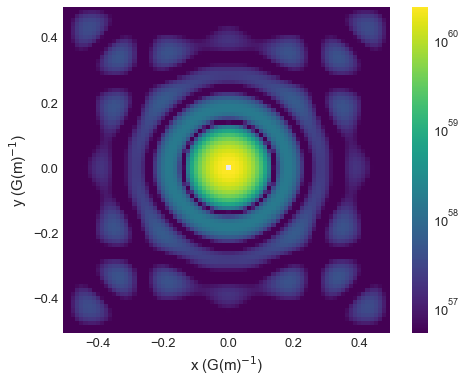

In [6]:
cs.plane(z=0).mpl.scalar(norm=LogNorm(vmin=5e56, vmax=cs.plane(z=0).array.max()))

In [ ]:
chiral = mag2exp.sans.c

In [36]:
cs.mesh

Mesh(region=Region(p1=(-506250000.0, -506250000.0, -506250000.0), p2=(493750000.0, 493750000.0, 493750000.0)), n=(80, 80, 80), bc='', subregions={}, attributes={'unit': '(m)$^{-1}$', 'fourierspace': True, 'isplane': False, 'realspace_mesh': Mesh(region=Region(p1=(-4e-08, -4e-08, -4e-08), p2=(4e-08, 4e-08, 4e-08)), n=(80, 80, 80), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': False})})

In [39]:
cut = cs.line(p1=(0,0,0), p2=(0.45e9,0,0), n=100)

In [40]:
import matplotlib.pyplot as plt

In [44]:
import matplotlib

In [41]:
cut.data

,r,px,py,pz,v
0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00
1,4.545455e+06,4.545455e+06,0.0,0.0,0.000000e+00
2,9.090909e+06,9.090909e+06,0.0,0.0,2.206184e+60
3,1.363636e+07,1.363636e+07,0.0,0.0,2.206184e+60
4,1.818182e+07,1.818182e+07,0.0,0.0,2.206184e+60
...,...,...,...,...,...
95,4.318182e+08,4.318182e+08,0.0,0.0,5.249147e+56
96,4.363636e+08,4.363636e+08,0.0,0.0,5.249147e+56
97,4.409091e+08,4.409091e+08,0.0,0.0,5.249147e+56
98,4.454545e+08,4.454545e+08,0.0,0.0,2.625454e+56


<IPython.core.display.Javascript object>


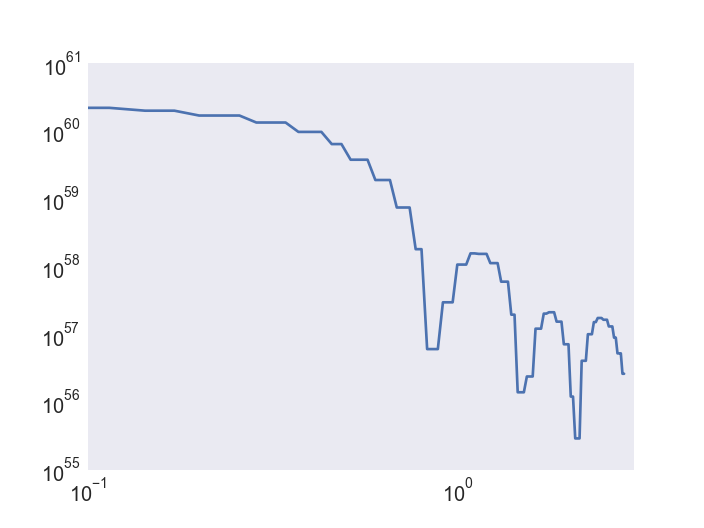

In [60]:
%matplotlib notebook
ax = plt.subplot()
ax.plot(2*np.pi*cut.data['r']/(1e9), cut.data['v'])
ax.axis([0.1, 3, 1e55, 1e61])
ax.loglog()
plt.show()

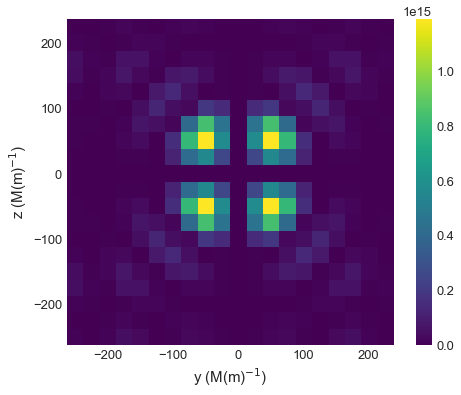

In [15]:
m_fft = system.m.fftn
np.power(np.abs(m_fft.y),2).plane(x=0).mpl.scalar()

In [1]:
import matplotlib.pyplot as plt

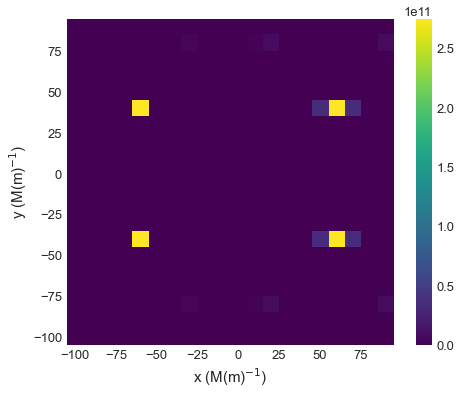

In [722]:
m_fft = system.m.fftn
m_fft *= m_fft.mesh.dV 
q = df.Field(m_fft.mesh, dim=3, value=lambda x: (1,1,1) if 0==np.linalg.norm(x) else x/np.linalg.norm(x))
f_p = q & m_fft & q

fpp = (np.power(np.abs(f_p.z), 2))
fpn = (np.power(np.abs(f_p.x-1j*f_p.y), 2))
fnp = (np.power(np.abs(f_p.x+1j*f_p.y), 2))
abs((fpn-fnp)/(-2*1j)).plane('z').mpl.scalar()

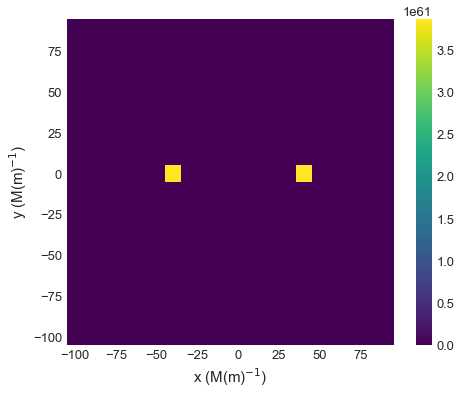

In [725]:
abs(sans_xsec(system.m, polarisation=[1,0,0], method='chiral', z=0)).mpl.scalar()

In [883]:
def sans_xsec(field, polarisation=[0,0,1], method='pp', **kwargs):
    m_fft = field.fftn
    m_fft *= m_fft.mesh.dV 
    q = df.Field(m_fft.mesh, dim=3, value=lambda x: (0,0,0) if 0==np.linalg.norm(x) else x/np.linalg.norm(x))
    f_p = q & m_fft & q
    
    initial = [0,0,1]
    if initial == polarisation:
        r = R.identity()
    else:
        fixed = np.cross(initial, polarisation)
        r = R.align_vectors([polarisation, fixed],
                            [initial, fixed])[0]
    p_x = [[0, 1], [1, 0]]
    p_y = [[0, -1j], [1j, 0]]
    p_z = [[1, 0], [0, -1]]
    p = np.array([p_x, p_y, p_z]) # Pauli matrices

    p_new = np.einsum('ij,ibc->jbc', r.as_matrix(), p)  # Rotate Pauli matrices
    f_trial = np.einsum('ijkl,lbc->ijkbc',  f_p.array, p_new)  # 
    
    if method in ('polarised_pp', 'pp'):
        return df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 0, 0, np.newaxis]), 2)).plane(**kwargs)
    elif method in ('polarised_pn', 'pn'):
        return df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 1, 0, np.newaxis]), 2)).plane(**kwargs)
    elif method in ('polarised_np', 'np'):
        return df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 0, 1, np.newaxis]), 2)).plane(**kwargs)
    elif method in ('polarised_nn', 'nn'):
        return df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 1, 1, np.newaxis]), 2)).plane(**kwargs)
    elif method in ('half_polarised_p', 'p'):
        return (sans_xsec(field, polarisation=polarisation, method='pp', **kwargs) + 
                sans_xsec(field, polarisation=polarisation, method='pn', **kwargs))
    elif method in ('half_polarised_n', 'n'):
        return (sans_xsec(field, polarisation=polarisation, method='nn', **kwargs) + 
                sans_xsec(field, polarisation=polarisation, method='np', **kwargs))
    elif method in ('unpolarised', 'unpol'): 
        return 0.5*(sans_xsec(field, polarisation=polarisation, method='p', **kwargs) + 
                    sans_xsec(field, polarisation=polarisation, method='n', **kwargs))
    elif method == 'chiral':
        return (sans_xsec(field, polarisation=polarisation, method='pn', **kwargs) - 
                sans_xsec(field, polarisation=polarisation, method='np', **kwargs))/(-2*1j)
    else:
        msg = f'Method {method} is unknown.'
        raise ValueError(msg)

PhysRevB.94.054424

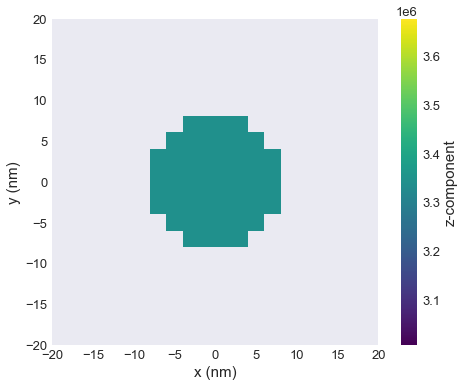

In [842]:
np.random.seed(1)

region = df.Region(p1=(-20e-9, -20e-9, -20e-9), p2=(20e-9, 20e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(2e-9, 2e-9, 2e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=10e-12)
                 + mm.DMI(D=2e-3, crystalclass='T')
                 + mm.Demag()
                 + mm.Zeeman(H=(0,0,0.8/(4*np.pi*1e-7))))

Ms = 4.2/(4*np.pi*1e-7)

def norm_fun(pos):
    x, y, z = pos
    
    if x**2 + y**2 + z**2 <= (8e-9)**2:
        return Ms
    else:
        return 0

def m_fun(pos):
    return (0,0,1)

system.m = df.Field(mesh, dim=3, value=m_fun, norm=norm_fun)
system.m.plane('z').mpl()

Running OOMMF (DockerOOMMFRunner) [2021/09/01 18:58]... (4.2 s)


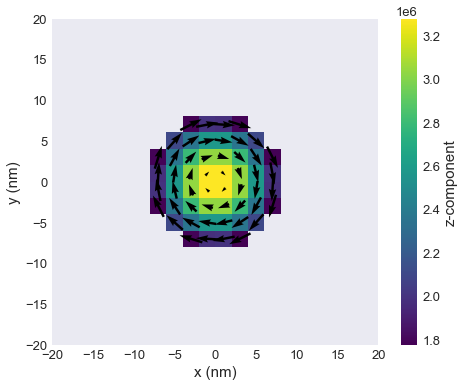

In [843]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

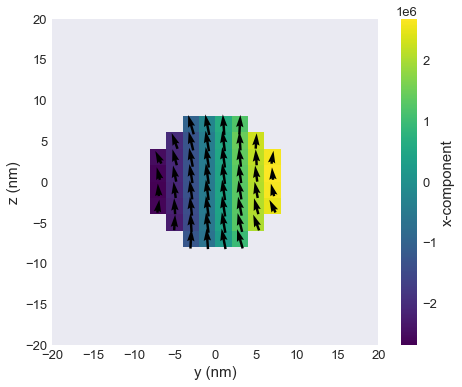

In [844]:
system.m.plane('x').mpl()

In [879]:
import oommfc as mc

In [880]:
mc.compute(system.energy.energy, system)

Running OOMMF (DockerOOMMFRunner) [2021/09/02 15:01]... (4.4 s)


-1.66784369607e-15

In [845]:
m_fft = system.m.fftn

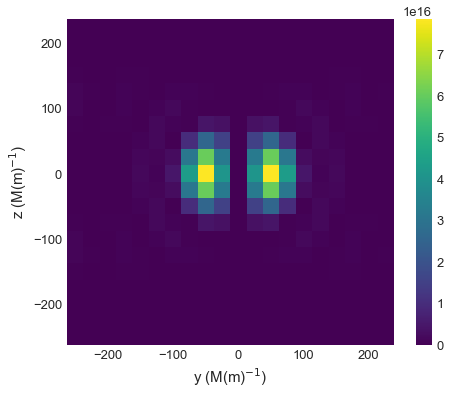

In [846]:
np.power(np.abs(m_fft.x),2).plane(x=0).mpl.scalar()

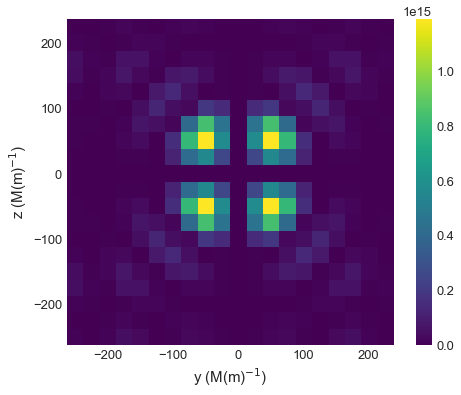

In [847]:
np.power(np.abs(m_fft.y),2).plane(x=0).mpl.scalar()

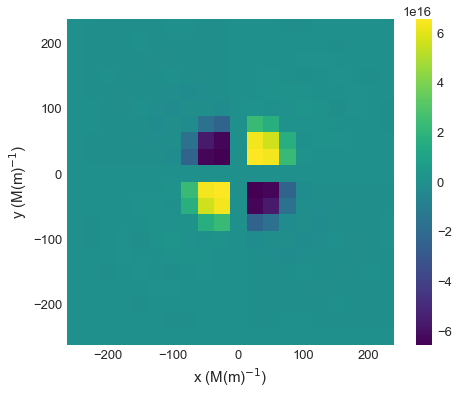

In [848]:
(-m_fft.x*m_fft.y.conjugate - m_fft.x.conjugate*m_fft.y).plane(z=0).real.mpl.scalar()

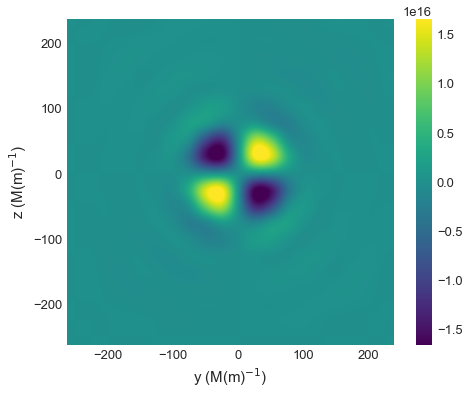

In [849]:
(-m_fft.y*m_fft.z.conjugate - m_fft.y.conjugate*m_fft.z).plane(x=0).real.mpl.scalar(interpolation='spline16')

In [850]:
2*np.pi*400*1e6/1e9

2.513274122871835

In [863]:
xs = sans_xsec(system.m, polarisation=[0,0,1], method='pn', z=0)

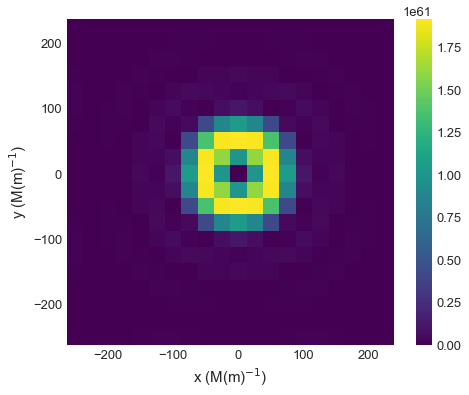

In [864]:
xs.real.mpl.scalar()

In [868]:
m_fft = system.m.fftn
q = df.Field(m_fft.mesh, dim=3, value=lambda x: (0,0,0) if 0==np.linalg.norm(x) else x/np.linalg.norm(x))
f_p = q & m_fft & q
fpp = (np.power(np.abs(f_p.z), 2))
fpn = (np.power(np.abs(f_p.x-1j*f_p.y), 2))
fnp = (np.power(np.abs(f_p.x+1j*f_p.y), 2))

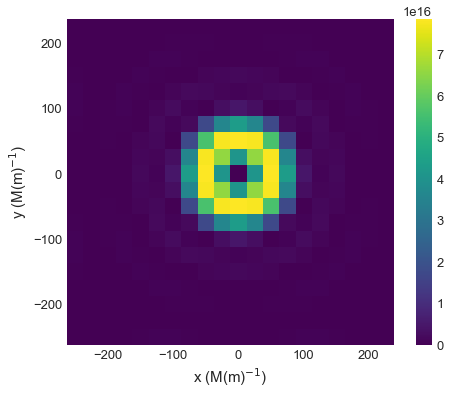

In [869]:
fpn.plane(z=0).real.mpl.scalar()

In [872]:
np.arctan2(0,0)

0.0

In [261]:
import mag2exp

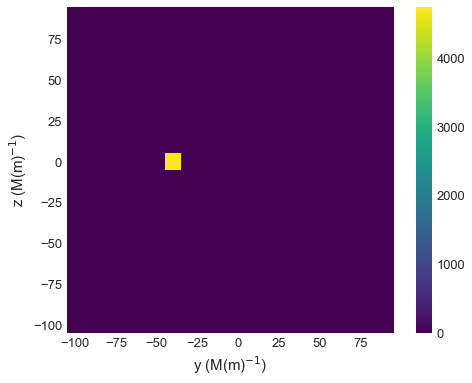

In [652]:
abs(mag2exp.sans.chiral_function(system.m, geometry='perpendicular')).plane('x').mpl.scalar()

In [648]:
cross_section = mag2exp.sans.cross_section(system.m, method='chiral', geometry='perpendicular')

ValueError: Method chiral is unknown.

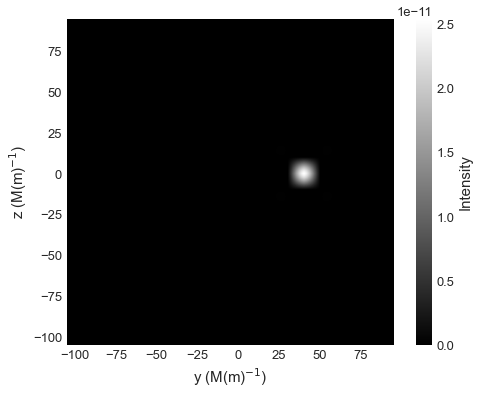

In [620]:
cross_section.real.mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

In [532]:
m_fft = system.m.fftn
q = df.Field(m_fft.mesh, dim=3, value=lambda x: (0,0,0) if 0==np.linalg.norm(x) else x/np.linalg.norm(x))
f_p = q & m_fft & q
fpp = (np.power(np.abs(f_p.z), 2))
fpn = (np.power(np.abs(f_p.x-1j*f_p.y), 2))

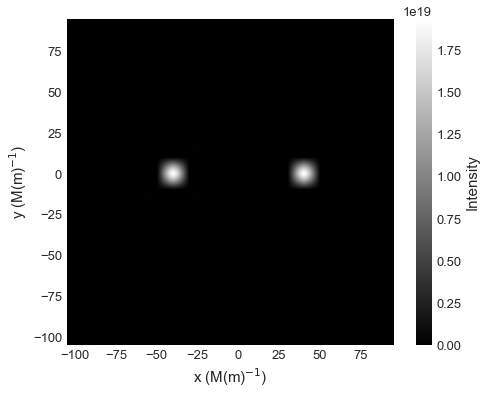

In [534]:
fpn.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

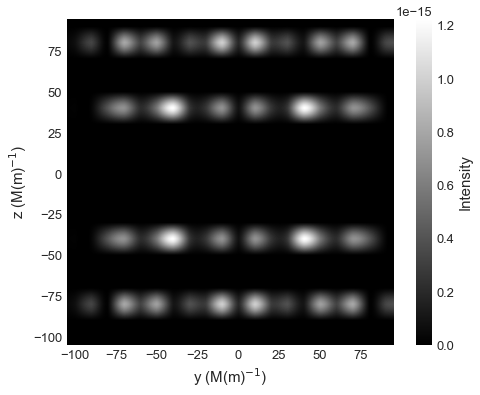

In [656]:
m_fft = system.m.fftn
q = df.Field(m_fft.mesh, dim=3, value=lambda x: (0,0,0) if 0==np.linalg.norm(x) else x/np.linalg.norm(x))
f_p = q & m_fft & q
fpp = (np.power(np.abs(f_p.x), 2))
fpn = (np.power(np.abs(f_p.y-1j*f_p.z), 2))
fnp = (np.power(np.abs(f_p.y+1j*f_p.z), 2))
fpn.plane(x=0).mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

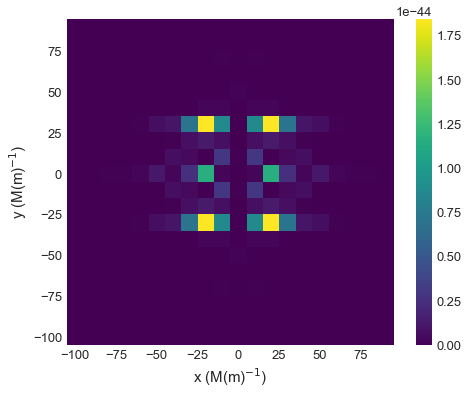

In [581]:
sans_xsec(system.m, polarisation=[0,0,1], method='pn', z=0).mpl.scalar()

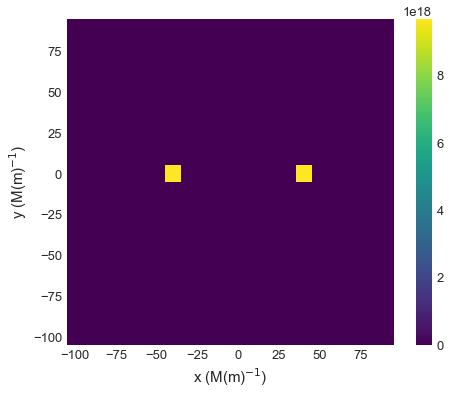

In [521]:
sans_xsec(polarisation=[1,0,1], method='nn', z=0).mpl.scalar()

In [460]:
sans_xsec(beam='z', polarisation=[0,0,1])

Field(mesh=Mesh(region=Region(p1=(-105000000.0, -105000000.0, -10000000.0), p2=(95000000.0, 95000000.0, 0.0)), n=(20, 20, 1), bc='', subregions={}, attributes={'unit': '(m)$^{-1}$', 'fourierspace': True, 'isplane': True, 'realspace_mesh': Mesh(region=Region(p1=(0.0, 0.0, 0.0), p2=(1e-07, 1e-07, 1e-07)), n=(20, 20, 20), bc='', subregions={}, attributes={'unit': 'm', 'fourierspace': False, 'isplane': False}), 'planeaxis': 2, 'point': -5000000.0, 'axis1': 0, 'axis2': 1}), dim=1)

In [454]:
p_x = [[0, 1], [1, 0]]
p_y = [[0, -1j], [1j, 0]]
p_z = [[1, 0], [0, -1]]
p = np.array([p_x, p_y, p_z])

p_new = np.einsum('ij,ibc->jbc', r.as_matrix(), p)
f_trial = np.einsum('ijkl,lbc->ijkbc', f_p.array, p_new)

fpp = df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 0, 0, np.newaxis]), 2))
fpn = df.Field(mesh=f_p.mesh, dim=1, value=np.power(np.abs(f_trial[..., 0, 1, np.newaxis]), 2))

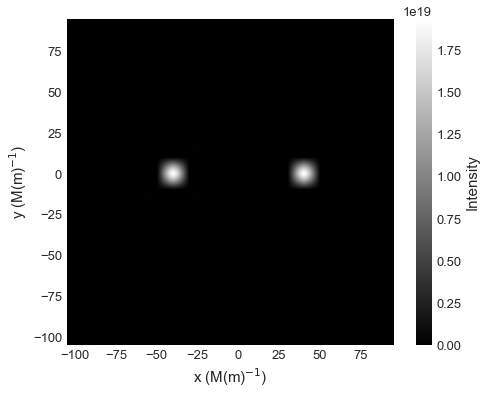

In [456]:
fpn.plane(z=0).mpl.scalar(cmap='gray', interpolation='spline16',
                              colorbar_label=r'Intensity')

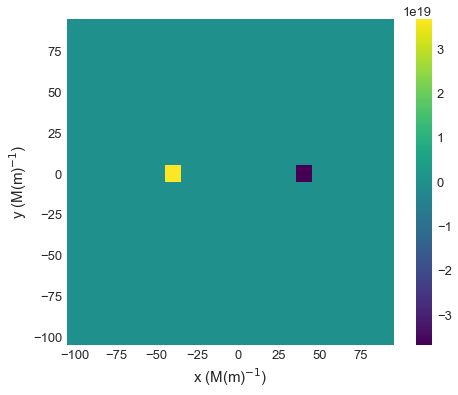

In [458]:
c = ((f_trial[..., 1, 0, np.newaxis]*f_trial[..., 0, 1, np.newaxis]) -
     0.5 * (f_trial[..., 1, 0, np.newaxis]**2 + f_trial[..., 0, 1, np.newaxis]**2))/1j
chiral = df.Field(mesh=f_p.mesh,
                  dim=1,
                  value=c)

chiral.plane(z=0).real.mpl.scalar()

### Importing Packages

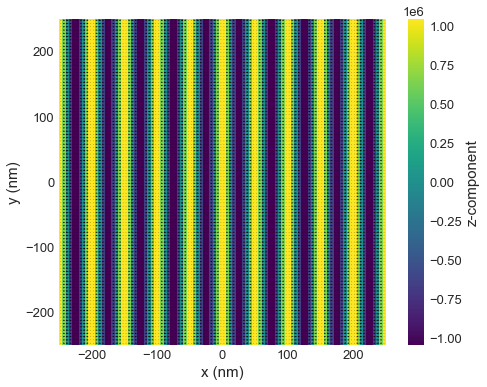

In [1]:
%matplotlib inline
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import ubermagutil.units as uu
import matplotlib.pyplot as plt

np.random.seed(1)

region = df.Region(p1=(-250e-9, -250e-9, 0), p2=(250e-9, 250e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

Ms = 1.1e6

def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    qy = 100e-9
    qz = 150e-9
    return (np.sin(2*np.pi*x/qx), 0, np.cos(2*np.pi*x/qx))

# create system with above geometry and initial magnetisation
field = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
field.plane('z').mpl()

In [2]:
import mag2exp

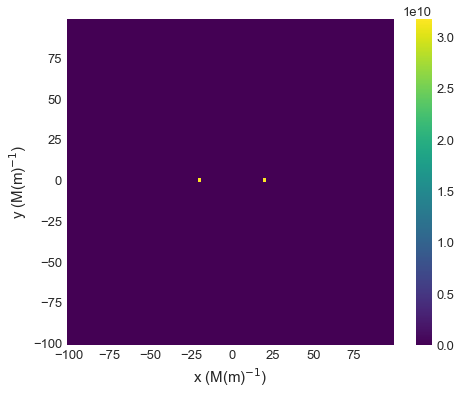

In [3]:
cs = mag2exp.sans.cross_section(field, method='unpol', geometry='parallel')
cs.real.mpl.scalar()

In [4]:
t1 = mag2exp.sans.cross_section(field, method='np', geometry='parallel') + mag2exp.sans.cross_section(field, method='nn', geometry='parallel')
t2 = mag2exp.sans.cross_section(field, method='pn', geometry='parallel') + mag2exp.sans.cross_section(field, method='pp', geometry='parallel')

In [5]:
np.allclose(t1.array, t2.array)

True

In [6]:
t2_1 = mag2exp.sans.cross_section(field, method='p', geometry='parallel')
np.allclose(t2.array, t2_1.array)

True

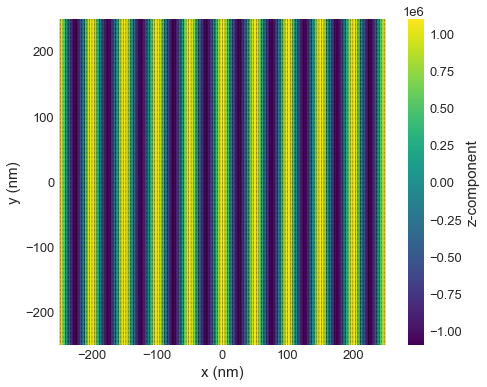

In [7]:
region = df.Region(p1=(-250e-9, -250e-9, 0), p2=(250e-9, 250e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(4e-9, 2e-9, 5e-9))

Ms = 1.1e6

def m_fun2(pos):
    x, y, z =pos
    qx = 50e-9
    qy = 100e-9
    qz = 150e-9
    return (np.sin(2*np.pi*x/qx), 0, np.cos(2*np.pi*x/qx))

# create system with above geometry and initial magnetisation
field2 = df.Field(mesh, dim=3, value=m_fun2, norm=Ms)
field2.plane('z').mpl()

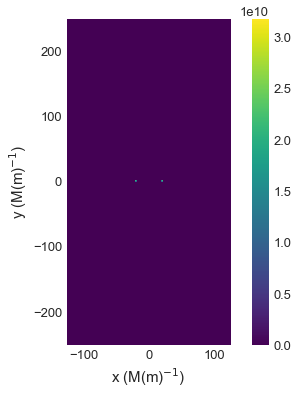

In [8]:
cs2 = mag2exp.sans.cross_section(field2, method='unpol', geometry='parallel')
cs2.real.mpl.scalar()

In [10]:
(np.max(cs.array)/np.max(cs2.array))

(1.0000000000000002+0j)

In [ ]:
(field2.mesh.dx/field.mesh.dx)

In [ ]:
a1 = np.prod(cs.mesh.region.pmax[:-1] - np.array(cs.mesh.region.pmin)[:-1])

In [ ]:
a2 = np.prod(cs2.mesh.region.pmax[:-1] - np.array(cs2.mesh.region.pmin)[:-1])

In [ ]:
a1/a2 * (field2.mesh.dx/field.mesh.dx)**2

In [ ]:
(field2.mesh.dx*field2.mesh.dy/(field.mesh.dx*field.mesh.dy))**2

In [ ]:
np.max(cs.array)/(cs.mesh.dx*cs.mesh.dy)

In [ ]:
np.max(cs2.array)/(cs2.mesh.dx*cs2.mesh.dy)

In [ ]:
100*(np.max(cs.array)-np.max(cs2.array))/np.max(cs.array)

In [ ]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [ ]:
system.m.plane('z').mpl()

In [ ]:
import mag2exp

In [ ]:
mag2exp.sans.cross_section(system.m, method='unpol', geometry='parallel').real.mpl()

In [ ]:
m_p_ft = (system.m * df.dz).integral(direction='z').fft2
theta = df.Field(m_p_ft.mesh, dim=1, value=lambda x: np.arctan2(x[1],x[0]))

q = df.Field(m_p_ft.mesh, dim=2, value=lambda x: [x[0],x[1]] / np.linalg.norm([x[0],x[1]]))

In [ ]:
abs((q.x*q.y).array - np.cos(theta.array)*np.sin(theta.array)).all() < 1e-5

In [ ]:
np.cos(theta.array)*np.sin(theta.array)

In [ ]:
q.mpl_vector(use_color=False)

${\bf Q} = {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right]$

In [ ]:
m_fft3 = system.m.fft3.plane(z=0)
def q_val(pos):
    x, y, z = pos
    return (0, y, z)
q = df.Field(m_fft3.mesh, dim=3, value=q_val, norm=1)

In [ ]:
sv = q & (q & m_fft3)
sv = (sv * df.dz)

In [ ]:
nsf = (sv.z*sv.z.conjugate)

In [ ]:
spc1 = (sv.x*sv.x.conjugate) + (sv.y*sv.y.conjugate) - 1j * (sv.x*sv.y.conjugate - sv.x.conjugate*sv.y) 
spc2 = (sv.x*sv.x.conjugate) + (sv.y*sv.y.conjugate) + 1j * (sv.x*sv.y.conjugate - sv.x.conjugate*sv.y) 

In [ ]:
spc1.real.mpl()

In [ ]:
(spc1+spc2+nsf+nsf).real.mpl()

In [ ]:
(sv * df.dz).integral(direction='z').z.real.mpl()

In [ ]:
sv.z.plane(z=0).real.mpl()

In [ ]:
m_p_ft = (system.m * df.dz).integral(direction='z').fft2

In [ ]:
m_p = system.m.integral(direction='z')

sans = (m_p.x.fft2*m_p.x.fft2.conjugate + m_p.y.fft2*m_p.y.fft2.conjugate).real

In [ ]:
sans.mpl_scalar(cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

SANS can have other geometries and polarisation of neutrons that I am planning to add. I just need to get my head around the differnt geometries.

\begin{align}
    {\bf Q} &= {\bf q} \times \left[ {\bf q} \times \widetilde{\bf M} \right] \\
    {\bf Q}_{\perp} &= \begin{pmatrix} 
                        -\widetilde{\bf M}_x \\
                        -\widetilde{\bf M}_y \cos^2\theta + \widetilde{\bf M}_z \sin\theta\cos\theta \\
                        \widetilde{\bf M}_y \sin\theta\cos\theta -\widetilde{\bf M}_z \sin2\theta
                       \end{pmatrix}  \\
    {\bf Q}_{\parallel } &= \begin{pmatrix} 
                             -\widetilde{\bf M}_x \sin^2\theta + \widetilde{\bf M}_y \sin\theta\cos\theta \\
                             \widetilde{\bf M}_x \sin\theta\cos\theta - \widetilde{\bf M}_y \cos^2\theta  \\
                             -\widetilde{\bf M}_z
                            \end{pmatrix} 
\end{align}
${\bf q}$ is the unit momentum transfer vector.

\begin{align}
    \frac{d\sum^{\pm \pm}}{d\Omega} &\sim |{\bf Q}_z|^2 \\
    \frac{d\sum^{\pm \mp}}{d\Omega} &\sim |{\bf Q}_x|^2 + |{\bf Q}_y|^2 \mp 
        i\left( {\bf Q}_x {\bf Q}^{\ast}_y - {\bf Q}^{\ast}_x {\bf Q}_y \right)
\end{align}
And

\begin{align}
    \frac{d\sum^{+}}{d\Omega} &= \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} \\
    \frac{d\sum^{-}}{d\Omega} &= \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{+}}{d\Omega} + \frac{d\sum^{-}}{d\Omega} \right) \\
    \frac{d\sum}{d\Omega} &= \frac{1}{2} \left( \frac{d\sum^{++}}{d\Omega} + \frac{d\sum^{+-}}{d\Omega} + 
                            \frac{d\sum^{--}}{d\Omega} + \frac{d\sum^{-+}}{d\Omega} \right)
\end{align}

In [ ]:
import mag2exp

In [ ]:
sans1 = mag2exp.sans.cross_section(system.m, method='unpolarised', geometry='perpendicular')

In [ ]:
sans2 = mag2exp.sans.cross_section(system.m, method='unpol', geometry='perpendicular')
fig, ax = plt.subplots(figsize=(8,8))
sans2.real.mpl_scalar(ax=ax, cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

In [ ]:
kx=ky=0.1
m_p_ft = (system.m * df.dz).integral(direction='z').fft2
k = df.Field(m_p_ft.mesh, dim=3, value=lambda x: x)
denom = (k.x**2 + k.y**2) / (k.x**2 + k.y**2
                                 + k.mesh.dx**2*kx**2 + k.mesh.dy**2*ky**2)**2
theta = np.arctan2(k.y.array.squeeze(), k.x.array.squeeze())

In [ ]:
plt.imshow(theta.T, origin='lower')
plt.colorbar()

In [ ]:
theta = theta[...,np.newaxis,np.newaxis]

In [ ]:
volume = system.m.mesh.region.edges[0]*system.m.mesh.region.edges[1]*system.m.mesh.region.edges[2]

In [ ]:
volume

In [ ]:
b_H = 2.91e8 
K = 8 * np.pi**3 * b_H**2 / volume

In [ ]:
K

In [ ]:
def sans_polarised_pp(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_nn(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_pn(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate - 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_polarised_np(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate + 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_half_polarised_p(Q):
    return sans_polarised_pp(Q) + sans_polarised_pn(Q)

def sans_half_polarised_n(Q):
    return sans_polarised_nn(Q) + sans_polarised_np(Q)

def sans_unpolarised(Q):
    return 0.5*(sans_half_polarised_p(Q) + sans_half_polarised_n(Q))

def chiral_function(Q):
    return (sans_polarised_pn(Q) - sans_polarised_np(Q)) / (-2 * 1j)

In [ ]:
Q_perp = (-m_p_ft.x << 
              -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
               m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)

In [ ]:
sans1 = K*sans_unpolarised(Q_perp)
sans1.real.mpl_scalar(cmap='gray',
         interpolation='spline16',
         colorbar_label=r'Intensity (arb.)')

In [ ]:
system.m.integral(direction='z').mpl()

In [ ]:
(system.m * df.dz).integral(direction='z').mpl()

In [ ]:
def sans_Q_perp(field, theta):
    m_p_ft = field.integral(direction='z').fft2
    Q_perp = (-m_p_ft.x << 
              -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
               m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)
    return Q_perp

def sans_Q_parallel(field, theta):
    m_p_ft = field.integral(direction='z').fft2
    Q_parallel = (-m_p_ft.x*np.sin(theta)**2 + m_p_ft.y*np.cos(theta)*np.sin(theta) << 
                  -m_p_ft.y*np.cos(theta)**2 + m_p_ft.x*np.cos(theta)*np.sin(theta) << 
                  m_p_ft.z)
    return Q_parallel

def sans_polarised_pp(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_nn(Q):
    return Q.z*Q.z.conjugate

def sans_polarised_pn(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate - 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_polarised_np(Q):
    return (Q.x*Q.x.conjugate + Q.y*Q.y.conjugate + 1j * (Q.x*Q.y.conjugate - Q.x.conjugate*Q.y))

def sans_half_polarised_p(Q):
    return sans_polarised_pp(Q) + sans_polarised_pn(Q)

def sans_half_polarised_n(Q):
    return sans_polarised_nn(Q) + sans_polarised_np(Q)

def sans_unpolarised(Q):
    return 0.5*(sans_half_polarised_p(Q) + sans_half_polarised_n(Q))

def chiral_function(Q):
    return (sans_polarised_pn(Q) - sans_polarised_np(Q)) / (-2 * 1j)

In [ ]:
cf = mag2exp.sans.chiral_function(system.m, geometry='parallel', theta=np.pi/2)
cf.imag.mpl_scalar()

In [ ]:
theta = 0
m_p_ft = m_p.fft2
chiral_f = (m_p_ft.x*m_p_ft.y.conjugate - m_p_ft.x.conjugate*m_p_ft.y) * np.cos(theta)**2
chiral_f += -(m_p_ft.x*m_p_ft.z.conjugate - m_p_ft.x.conjugate*m_p_ft.z) * np.cos(theta) * np.sin(theta)

chiral_f.imag.mpl_scalar()

In [ ]:
cf2a = mag2exp.sans.cross_section(system.m, method='pn', geometry='perpendicular')
cf2b = mag2exp.sans.cross_section(system.m, method='np', geometry='perpendicular')
cf2 = (cf2a-cf2b)/(-2 *1j)
cf2.imag.mpl_scalar()

In [ ]:
Q = mag2exp.sans.magnetic_interaction_vector(system.m, geometry='perpendicular')

In [ ]:
sans1.real.mpl_scalar()

In [ ]:
theta = 0#np.pi/2
Q = sans_Q_perp(system.m, theta)
sans_unpolarised(Q).real.mpl_scalar()

In [ ]:
sans_polarised_pp(system.m, theta, geometry='perp')

In [ ]:
theta = 0#p.pi/2

m_p_ft = m_p.fft2
Q_perp = (-m_p_ft.x << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.z*np.cos(theta)*np.sin(theta) << 
          m_p_ft.y*np.cos(theta)*np.sin(theta) - m_p_ft.z*np.sin(theta)**2)

Q_para = (-m_p_ft.x*np.sin(theta)**2 + m_p_ft.y*np.cos(theta)*np.sin(theta) << 
          -m_p_ft.y*np.cos(theta)**2 + m_p_ft.x*np.cos(theta)*np.sin(theta) << 
          m_p_ft.z)

In [ ]:
cross_perp_pp = Q_perp.z*Q_perp.z.conjugate
cross_perp_nn = Q_perp.z*Q_perp.z.conjugate
cross_perp_pn = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))
cross_perp_np = (Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate - 
            1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y))

In [ ]:
p=1/2
sf=1
cross_perp_sanspol = (cross_perp_pp +
                      Q_perp.x*Q_perp.x.conjugate + Q_perp.y*Q_perp.y.conjugate + 
                      1j * (Q_perp.x*Q_perp.y.conjugate - Q_perp.x.conjugate*Q_perp.y) *
                      (2*p-1) * (2*sf-1))

In [ ]:
cross_perp_sanspol.real.mpl()

In [ ]:
cross_perp_pn.real.mpl()

In [ ]:
t_sans = 0.5 * (cross_pp + cross_pn + cross_np + cross_nn)

In [ ]:
t_sans.real.mpl_scalar(cmap='gray', interpolation='spline16', colorbar_label=r'Intensity (arb.)')

In [ ]:
(cross_perp_pn-cross_perp_np).real.mpl_scalar()

In [ ]:
((t_sans-sans)/sans).real.mpl()

In [ ]:
cross_perp_pp.real.mpl()

In [8]:
import numpy as np
import discretisedfield as df
from scipy.spatial.transform import Rotation as R

In [15]:
polarisation = (0,1,0)

initial = [0,0,1]
if initial == polarisation:
    r = R.identity()
else:
    fixed = np.cross(initial, polarisation)
    r = R.align_vectors([polarisation, fixed],
                        [initial, fixed])[0]
p_x = [[0, 1], [1, 0]]
p_y = [[0, -1j], [1j, 0]]
p_z = [[1, 0], [0, -1]]
p = np.array([p_x, p_y, p_z]) # Pauli matrices

p_new = np.einsum('ij,ibc->jbc', r.as_matrix(), p)

In [16]:
p

array([[[ 0.+0.j,  1.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]],

       [[ 1.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j]]])

In [17]:
p_new

array([[[ 0.+0.j,  1.+0.j],
        [ 1.+0.j,  0.+0.j]],

       [[-1.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j]],

       [[ 0.+0.j,  0.-1.j],
        [ 0.+1.j,  0.+0.j]]])

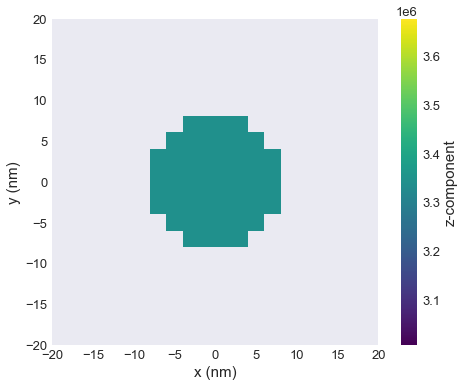

In [20]:
np.random.seed(1)

region = df.Region(p1=(-20e-9, -20e-9, -20e-9), p2=(20e-9, 20e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(2e-9, 2e-9, 2e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=10e-12)
                 + mm.DMI(D=2e-3, crystalclass='T')
                 + mm.Demag()
                 + mm.Zeeman(H=(0,0,0.8/(4*np.pi*1e-7))))

Ms = 4.2/(4*np.pi*1e-7)

def norm_fun(pos):
    x, y, z = pos
    
    if x**2 + y**2 + z**2 <= (8e-9)**2:
        return Ms
    else:
        return 0

def m_fun(pos):
    return (0,0,1)

field = df.Field(mesh, dim=3, value=m_fun, norm=norm_fun)
field.plane('z').mpl()

In [22]:
from scipy.spatial.transform import Rotation

In [23]:
m_fft = field.fftn
m_fft *= m_fft.mesh.dV  # Normalisation
q = df.Field(m_fft.mesh,
             dim=3,
             value=(lambda x: (0, 0, 0)
                    if 0 == np.linalg.norm(x) else x/np.linalg.norm(x)))
magnetic_interaction = q & m_fft & q

# Rotation of Pauli matrices
initial = [0, 0, 1]
if initial == polarisation:
    r = Rotation.identity()
else:
    fixed = np.cross(initial, polarisation)
    r = Rotation.align_vectors([polarisation, fixed],
                               [initial, fixed])[0]
p_x = [[0, 1], [1, 0]]
p_y = [[0, -1j], [1j, 0]]
p_z = [[1, 0], [0, -1]]
p = np.array([p_x, p_y, p_z])
p_new = np.einsum('ij,ibc->jbc', r.as_matrix(), p)  # Rotate Pauli matrices

# Apply function to Pauli
magnetic_interaction_new = np.einsum('ijkl,lbc->ijkbc',
                                     magnetic_interaction.array,
                                     p_new)
cs = np.power(np.abs(magnetic_interaction_new), 2)

In [26]:
a = np.array([[1, 2],
              [3, 4]])

In [28]:
a.reshape((4)).shape

(4,)

In [29]:
a.reshape((4))

array([1, 2, 3, 4])

In [31]:
cs.reshape([*cs.shape[:3], 4]).shape

(20, 20, 20, 4)